In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
from imgaug import augmenters as iaa
import random

# File Renaming
Following function renames the files, as original format contains spaces and parenthesis that may lead to errors during file handling

In [2]:
def rename_files_for_consistency(folder, class_name):
    for fname in os.listdir(folder):
        if fname.endswith('.png'):
            # Look for patterns like benign (12).png or benign (12)_mask.png
            match = re.match(rf'{class_name} \((\d+)\)(.*?)\.png', fname)
            if match:
                num = match.group(1)
                suffix = match.group(2)  # '_mask' or ''
                # Build new filename
                new_fname = f'{class_name}_{num}{suffix}.png'
                os.rename(os.path.join(folder, fname), os.path.join(folder, new_fname))
                print(f'Renamed: {fname} -> {new_fname}')

data_dir = '/Users/jessica/Documents/GitHub/breast_cancer_detection/data/raw'
for cls in ['benign', 'malignant', 'normal']:
    folder = os.path.join(data_dir, cls)
    rename_files_for_consistency(folder, cls)

# Visualising Pre-Processed Data

This function, load_images_with_masks, does the following:

1. Initializes lists to store loaded images, their corresponding masks, and class labels.
2. Loops through each class (folder): For example, the folders are benign, malignant, normal. Each gets an integer label (0 for benign, 1 for malignant, 2 for normal).
3. Goes through every file in the folder. If it's an image (does not contain _mask and ends with .png):
    1. Loads the main image (in grayscale).
    2. Figures out the matching mask name using the same number (e.g., benign-1_mask.png for benign-1.png).
    3. Loads the mask if it exists (again as grayscale), else keeps it as None (useful for normal images which may not have masks).
    4. Stores the loaded image, its label (0, 1, or 2), and the mask.
4. Returns three lists:
    1. images: all loaded image arrays
    2. masks: all loaded mask arrays (or None if not present)
    3. labels: an integer label for each image (0, 1, or 2)

In [4]:
def load_images_with_masks(data_dir, classes):
    """
    Loads images and corresponding mask files from class folders, assigns integer labels.
    Args:
        data_dir (str): Path to the data directory with class subfolders.
        classes (list): List of class names (folder names).
    Returns:
        images (list): List of loaded images.
        masks (list): List of loaded mask images (or None for normal).
        labels (list): Integer label for each sample.
    """
    images, masks, labels = [], [], []
    for label, cls in enumerate(classes):
        folder = os.path.join(data_dir, cls)
        for fname in os.listdir(folder):
            if fname.endswith('.png') and '_mask' not in fname:
                parts = fname.split('.')[0].split('_')
                if len(parts) != 2:
                    print(f"Skipping file with unexpected format: {fname}")
                    continue
                num = parts[1]
                mask_name = f"{cls}_{num}_mask.png"
                mask_path = os.path.join(folder, mask_name) if os.path.exists(os.path.join(folder, mask_name)) else None
                img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if mask_path else None
                images.append(img)
                masks.append(mask)
                labels.append(label)
    return images, masks, labels

This function crops an image to only include the region inside the mask (typically where a lesion or abnormal region is found).
1. Check if mask is present: If mask is None, just return the original image, as there’s nothing to crop.
2. Find contours in the mask: Contours are detected inside the mask image, which is usually white in lesion areas and black in background.
3. cv2.findContours returns the coordinates of the boundary around the white region.
4. Get bounding box: If any contour exists, get the smallest rectangle (bounding box) that contains the lesion using cv2.boundingRect(contours[0]). The coordinates x, y, w, h tell you where this box starts and its width and height.
5. Crop original image: Use these coordinates to crop the original image to focus on just the region inside the mask.
6. Fallback: If no contours are found (mask is all black, or something is wrong), just return the original image.

For classical machine learning models (like SVM, k-NN), cropping to lesion can be helpful since you want discriminative features and lower dimensionality.

In [5]:
def apply_mask_and_crop(image, mask):
    """
    Crops the input image to the bounding box of the mask region.
    Args:
        image (np.array): Grayscale image array.
        mask (np.array): Corresponding mask array (white lesion, black background).
    Returns:
        cropped_img (np.array): Cropped image array.
    """
    if mask is None:
        return image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped_img = image[y:y+h, x:x+w]
        return cropped_img
    else:
        return image  # fallback if no contour found

This function creates a two-channel image: one channel is the original grayscale image, the other is the mask. This can help you guide your model or processing to pay more attention to the mask area.
1. Check if mask is present: If there is no mask, create an all-black mask (same shape as image). This ensures dimensions match for all samples.
2. Stack image and mask: Use np.stack([image, mask], axis=-1) to create a new array with two channels, so every pixel has both its intensity and whether it’s inside the mask.

For deep learning (CNNs), preserving context by providing the whole image and the mask as another channel can help the model learn both local features (lesion) and global structure (normal tissue), improving performance.

In [6]:
def concatenate_mask_channel(image, mask):
    """
    Adds mask as a second channel to the image.
    Args:
        image (np.array): Grayscale image.
        mask (np.array): Grayscale mask or None.
    Returns:
        img_with_mask (np.array): 2-channel image (image, mask).
    """
    if mask is None:
        mask = np.zeros_like(image)
    return np.stack([image, mask], axis=-1)

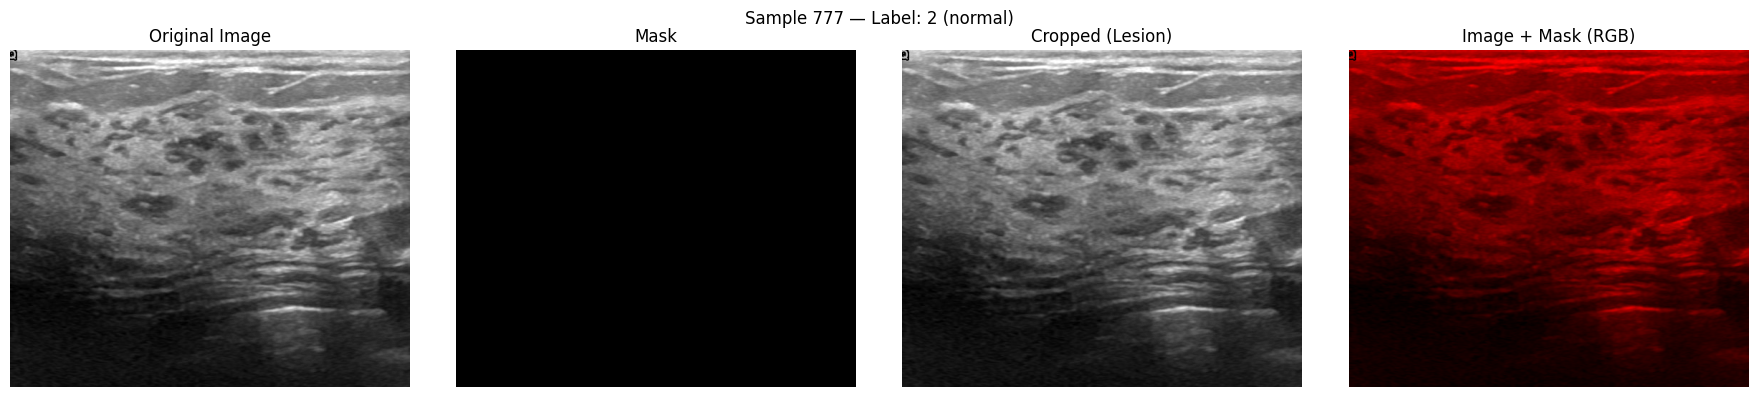

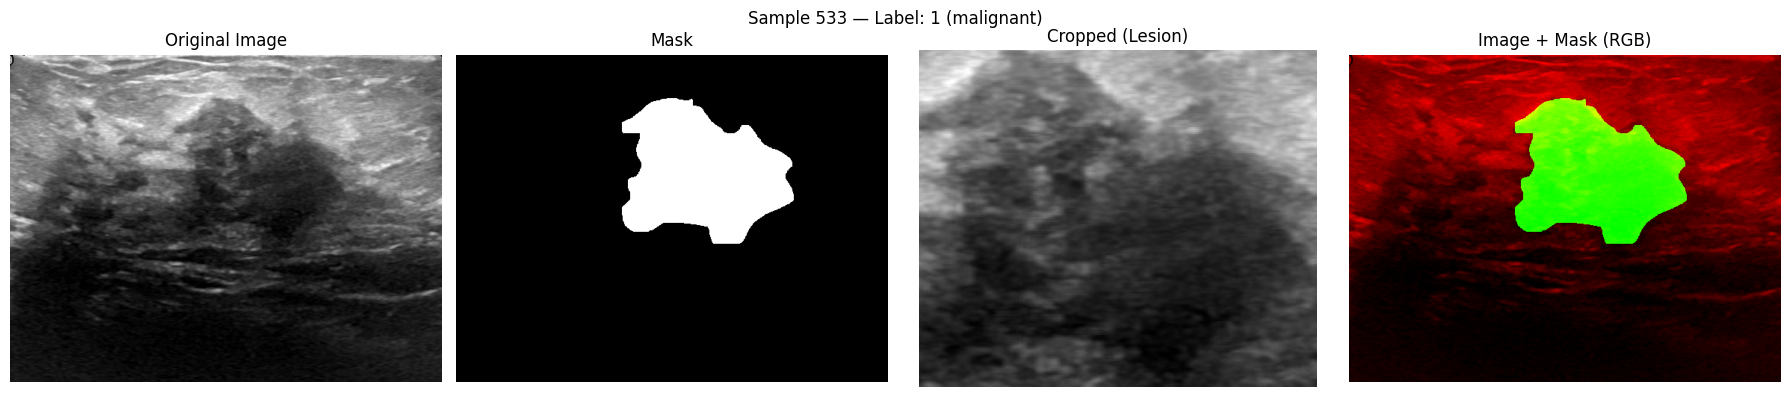

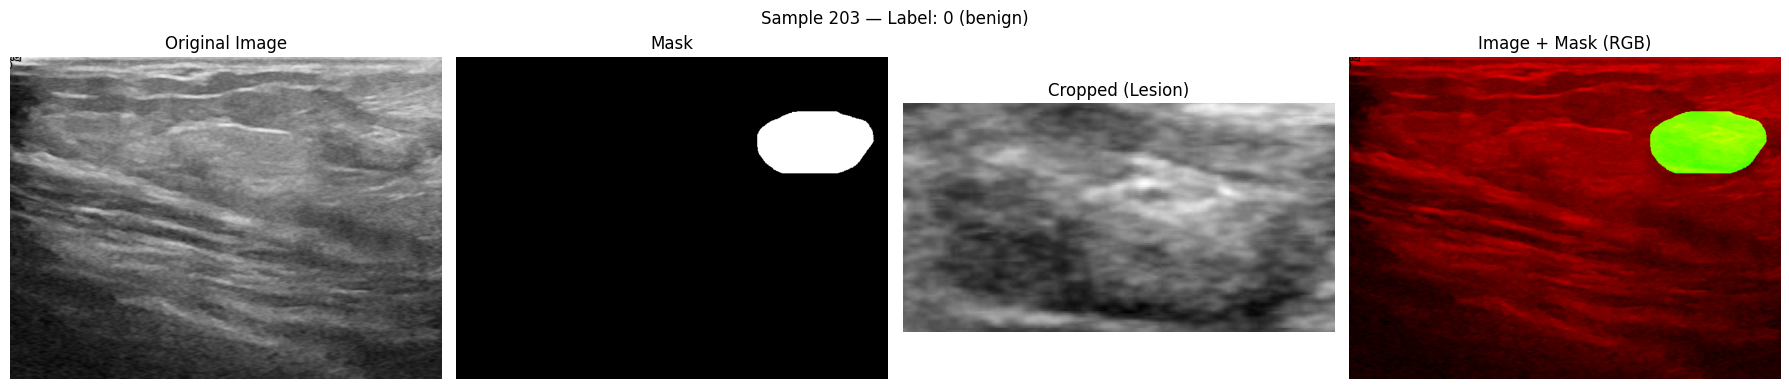

In [8]:
#Initialise n for number of samples to visualise
n = 3

classes = ['benign', 'malignant', 'normal']
images, masks, labels = load_images_with_masks("/Users/jessica/Documents/GitHub/breast_cancer_detection/data/raw", classes)

idxs = random.sample(range(len(images)), n)
for idx in idxs:
    img = images[idx]
    mask = masks[idx]
    lab = labels[idx]
    label_text = classes[lab]
    cropped = apply_mask_and_crop(img, mask)
    img2ch = concatenate_mask_channel(img, mask)  # shape: (H, W, 2)

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    if mask is not None:
        axes[1].imshow(mask, cmap='gray')
    else:
        axes[1].imshow(np.zeros_like(img), cmap='gray')
    axes[1].set_title('Mask')
    axes[2].imshow(cropped, cmap='gray')
    axes[2].set_title('Cropped (Lesion)')

    # For the 2-channel version, show red=image, green=mask (yellow=overlap)
    rgb = np.zeros((*img.shape, 3), dtype=np.float32)
    rgb[...,0] = img/255.0
    rgb[...,1] = mask/255.0 if mask is not None else 0
    axes[3].imshow(rgb)
    axes[3].set_title('Image + Mask (RGB)')
    for ax in axes:
        ax.axis('off')
    plt.suptitle(f"Sample {idx} — Label: {lab} ({label_text})")
    plt.tight_layout()
    plt.show()
